# MODIS Climate Marble
      Date                        Description
    02/27/2018            Set up the main framework.
    02/28/2018            The main framework is set.
    03/12/2018            Daily results are all set and process the monthly means. 

### I. Framework

The whole project is based on the existing codes. The MODIS relevant documents can be found https://mcst.gsfc.nasa.gov/content/l1b-documents. 

I think the final MODIS climate marble should be based on the global view from each day. This approach also should benefit the moving average to get 365 pics. 

One question come up, how to deal with the sun glint region? Like MISR, I didn't do anything for that. Will it contribute to the evident bright stripe?

In [ ]:
# taking MOD021KM.A2013198.0210.hdf as an example


# Import
from zyz_core import np, plt, os, time, tqdm
from zyz_data import MOD02_select_chs, MOD02_retrieve_field
from zyz_plot import draw_modis_enhanced_RGB


working_dir = '/Users/yizhe/OneDrive - University of Illinois - Urbana/test_MODIS_ClimateMarble/MODIS_20180112'


### II. Main function

    If we want to make VZA < 30°, the vza index range should be [70, 201];
    If we want to make VZA < 40°, the vza index range should be [48, 223].

In [ ]:

def main_process_single_MOD02file(mod_file_dir):

    # We may want to retrieve VZA first and apply a criterion on it (need to be tested). 
    # Here we do not consider the VZA field.
    vza = MOD02_retrieve_field(mod_file_dir, 'SensorZenith')[:]/100.
    

    # Reading Lat/Lon and the radiance data.
    lats = MOD02_retrieve_field(mod_file_dir, 'Latitude')[:]
    lons = MOD02_retrieve_field(mod_file_dir, 'Longitude')[:]
    ch1 = MOD02_select_chs(mod_file_dir, [1])[:, :, 0]
    rad_shape = ch1.shape
    ch1_1d = ch1.ravel()


    # Assumption 1: repeat lats and lons 5 times to fit the radiance dimensions
    lats_new = np.repeat(np.repeat(lats, 5, axis=0), 5, axis=1)[:rad_shape[0], : rad_shape[1]]
    lons_new = np.repeat(np.repeat(lons, 5, axis=0), 5, axis=1)[:rad_shape[0], : rad_shape[1]]
    lats_float_1d = lats_new.ravel()
    lons_float_1d = lons_new.ravel()
    lats_int_1d = lats_float_1d.astype('int32')
    lons_int_1d = lons_float_1d.astype('int32')
    lats_decimal_1d = lats_float_1d - lats_int_1d
    lons_decimal_1d = lons_float_1d - lons_int_1d
#     print lats_float_1d, lats_int_1d, lats_decimal_1d

    # We have a global grid of 1 degree resolution (180*360), the corresponding indexes are showing below
    #                  0 (90 ~ 89)
    #    0(-180 ~ -179)          359(179 ~ 180)
    #                180 (89 ~ 90)
#     global_radiance_sum = np.zeros((180, 360))
#     global_radiance_num = np.zeros((180, 360))

    # The following part is just sorting the radiances into lat/lon bins. 
    # For example, if a FOV's lat(lon) is 38.3(118.2), it should belong to the bin of (38°N--39°N) and (118°E--119°E),
    # which corresponds to the y index of (90-38=52) and to the x index of (118+180=298). So, we just need to add the 
    # radiance to variable global_radiance_sum[52, 298] and add 1 to the variable global_radiance_sum[52, 298].
#     for irad, ilat, ilon in zip(ch1_1d, lats_int_1d, lons_int_1d):
#         y_idx = 90 - ilat
#         x_idx = 180 + ilon
#         global_radiance_sum[y_idx, x_idx] += irad
#         global_radiance_num[y_idx, x_idx] += 1


    # Now, what if we use 0.5 degree resolution (360*720), the corresponding indexes are showing below
    #                  0 (90 ~ 89.5)
    #    0(-180 ~ -179.5)          719(179.5 ~ 180)
    #                360 (89.5 ~ 90)
    global_radiance_sum = np.zeros((360, 720))
    global_radiance_num = np.zeros((360, 720))

    # The following part is just sorting the radiances into lat/lon bins. 
    # For example, if a FOV's lat(lon) is 38.3(118.2), it should belong to the bin of (38°N--38.5°N) and (118°E--118.5°E).
    # It is slightly more complicated as we need to deal with 0.5 degree.
    for irad, ilat_dcm, ilon_dcm, ilat_int, ilon_int in zip(ch1_1d, lats_decimal_1d, lons_decimal_1d, lats_int_1d, lons_int_1d):
        if (irad > 1000) or (irad < 5):
            continue
            
        y_idx = 90 - ilat_int
        x_idx = 180 + ilon_int
        
        if abs(ilat_dcm) < 0.5:
            y_idx = y_idx * 2
        else:
            y_idx = y_idx * 2 + 1
        
        if abs(ilon_dcm) < 0.5:
            x_idx = x_idx * 2
        else:
            x_idx = x_idx * 2 + 1
        
        global_radiance_sum[y_idx, x_idx] += irad
        global_radiance_num[y_idx, x_idx] += 1


    return global_radiance_sum, global_radiance_num




### III. Process

In [ ]:


global_radiance_sum = np.zeros((360, 720))
global_radiance_num = np.zeros((360, 720))
    
files = os.listdir(working_dir)
    
for imod_file in tqdm(files, miniters=10):
    if imod_file.startswith('MOD021KM'):
#         t0 = time.time()
#         print imod_file
        mod_file_dir = os.path.join(working_dir, imod_file)

        tmp_rad_sum, tmp_rad_num = main_process_single_MOD02file(mod_file_dir)

        global_radiance_sum += tmp_rad_sum
        global_radiance_num += tmp_rad_num
#         print time.time() - t0


### IV. Show results

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(global_radiance_sum/global_radiance_num, vmax=400)
# plt.colorbar()
plt.savefig('test.png', dpi=300)
plt.show()

### 03/12/2018

1) 创建每年的文件夹并将相应年份的数据存入

In [ ]:
from zyz_core import np, os


data_dir = os.path.join("/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily/", 'LW_P2')

# Step 1
for iyr in range(2000, 2016):
    os.mkdir(os.path.join(data_dir, str(iyr)))


# Step 2
for ifile in os.listdir(data_dir):
#     print ifile
    if ifile.endswith('.npz') == False:
        continue
    file_0 = os.path.join(data_dir, ifile)
    
    iyr = ifile[:4]
    file_1 = os.path.join(os.path.join(data_dir, iyr), ifile)
    os.rename(file_0, file_1)

2) 对每年数据按月划分，区分闰年2000, 2004, 2008, 2012  
这块内容参见目录下的split_by_month.py, 生成的月平均数据存在scratch/results/monthly目录下

### 03/13/2018

3) 对月平均数据进行处理，得到16年（2000--2015）每个月的平均值。输出为12个文件。

In [ ]:
cats = ['VIS', 'SWIR_P1', 'SWIR_P2', 'LW_P1', 'LW_P2']


working_dir = '/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily/'
output_dir = '/u/sciteam/smzyz/scratch/results/'

for icat in cats[3:]:
    # iterating each month and collect available monthly mean results of the specified category.
    for imon in tqdm(range(1, 13), miniters=1):

        rad_all = np.zeros((1800, 3600, 8))
        num_all = np.zeros((1800, 3600, 8))
        for iyr in range(2000, 2016):
            ifile = "{}_{}_{}.npz".format(icat, iyr, imon)
            inpz = np.load(os.path.join(working_dir, ifile))

            rad_all += inpz['rad_all']
            num_all += inpz['num_all']

        mean_rad = np.array(rad_all / num_all)

        np.savez_compressed(os.path.join(output_dir, "{}_{}.npz".format(icat, imon)), mean_rad = mean_rad)

In [ ]:

from zyz_core import np, os, tqdm

working_dir = "/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily/"
output_dir = "/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily_mean/"

cats = ['VIS', 'SWIR_P1', 'SWIR_P2', 'LW_P1', 'LW_P2']

for icat in cats[:1]:
    # iterating each month and collect available monthly mean results of the specified category.
    for iday in tqdm(range(1, 367), miniters=1):
        
        if icat in ['VIS', 'SWIR_P2']:
            rad_all = np.zeros((3600, 7200, 7))
            num_all = np.zeros((3600, 7200, 7))
        else:
            rad_all = np.zeros((3600, 7200, 8))
            num_all = np.zeros((3600, 7200, 8))
            
        for iyr in range(2000, 2016):
            ifile = "{}.{}.npz".format(iyr, str(iday).zfill(3))
            try:
                inpz = np.load(os.path.join(working_dir+"{}/{}".format(icat, iyr), ifile))

                rad_all += inpz['rad_sum']
                num_all += inpz['rad_num']
            except Exception as err:
                print "Error: {}".format(err)

        mean_rad = np.array(rad_all / num_all)

        np.savez_compressed(os.path.join(output_dir, "{}_{}.npz".format(icat, str(iday).zfill(3))), mean_rad = mean_rad)

In [ ]:
from postprocess_climate_by_runningmean import monthly_mean_rewrite_netCDF4

monthly_mean_rewrite_netCDF4('LW_P2')

### 03/15/2018

遍历文件夹，输出文件数量。

In [ ]:
import numpy as np
import os


cnt = []
tot = 0
for iyr in range(2000, 2016):
    path = '/u/sciteam/smzyz/scratch/results/VIS/{}'.format(iyr)
    
    files = os.listdir(path)
    print len(files)
    
#     for iday in range(1, 367):
#         path_1 = os.path.join(path, str(iday).zfill(3))
        
#         try:
#             files = os.listdir(path_1)
#         except OSError as err:
#             continue
            
#         for ifile in files:
#             if ifile.endswith('.hdf'):
#                 cnt.append(os.path.join(path_1, ifile))
        
#         print len(cnt) - tot
#     tot = len(cnt)

In [ ]:
from zyz_core import h5py


npz_file = '/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_01deg/daily/VIS/2000/2000.061.npz'

data = np.load(npz_file)
rad_sum = data['rad_sum']
rad_num = data['rad_num']



h5_file = '/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_01deg/daily/VIS/2000/2000.061.h5'

with h5py.File(h5_file, 'a') as h5f:
    h5f.create_dataset('/rad_sum', data=rad_sum, compression='gzip', compression_opts=9)
    h5f.create_dataset('/rad_num', data=rad_num, compression='gzip', compression_opts=9)

In [ ]:
90*20 - (int(-0.782/0.05))

In [ ]:

def latlon_to_idx(lat_int, lat_decimal, lon_int, lon_decimal, num):
    """
    num: 1/resolution
    """
    # Latitude part
    if lat_int + lat_decimal < 0:
        idx_lat = (90 - lat_int) * num - int(lat_decimal * num)
    else:
        idx_lat = (90 - lat_int) * num - int(lat_decimal * num) - 1
        
    # Longitude part
    if lon_int + lon_decimal < 0:
        idx_lon = (180 + lon_int) * num + int(lon_decimal * num) - 1
    else:
        idx_lon = (180 + lon_int) * num + int(lon_decimal * num)
    
    return int(idx_lat), int(idx_lon)
        
    

In [ ]:
from helper_func import *
import sys


SPATIAL_RESOULITON = 0.05
NUM_POINTS = 1/SPATIAL_RESOULITON
NUM_LATS = int(180/SPATIAL_RESOULITON)
NUM_LONS = int(360/SPATIAL_RESOULITON)
NUM_CHAN = 7 # 15 # 16
CATEGORY = 1 # 2 # 3



# mod_file_dir = '/u/sciteam/smzyz/scratch/data/MODIS/MOD021KM/2000/100/MOD021KM.A2000100.0010.006.2014230132236.hdf'
def main_process_single_MOD02file(mod_file_dir):

    # We may want to retrieve VZA first and apply a criterion on it (need to be tested).    
    BOUNDING_LOW_VZA = 48#28 #48 #70
    BOUNDING_HIG_VZA = 233#242 #233 #201


    # Read Lat/Lon.
    lats = MOD02_retrieve_field(mod_file_dir, 'Latitude')[:, BOUNDING_LOW_VZA:BOUNDING_HIG_VZA]
    lons = MOD02_retrieve_field(mod_file_dir, 'Longitude')[:, BOUNDING_LOW_VZA:BOUNDING_HIG_VZA]
    geo_shape = lats.shape

        
    # Read radiances and resample into coarser resolution (5 km).
    rads, max_values = MOD02_retrieve_radiance_all(mod_file_dir, CATEGORY)
    rads_1km = rads[:, BOUNDING_LOW_VZA*5:BOUNDING_HIG_VZA*5]
    rads_5km = np.array([[rads_1km[j*5:(j+1)*5, i*5:(i+1)*5, :].mean(axis=1).mean(axis=0) 
                                for i in range(geo_shape[1])] for j in range(geo_shape[0])])
    rads_shape = rads_5km.shape
    
    # Calculate Lat/Lon integers and decimals, which will be used as indexes later. 
    lats_int_2d = lats.astype('int32')
    lons_int_2d = lons.astype('int32')
    lats_decimal_2d = lats - lats_int_2d
    lons_decimal_2d = lons - lons_int_2d

    
    # Now, what if we use 0.1 degree resolution (1800*3600), the corresponding indexes are showing below
    global_radiance_sum = np.zeros((NUM_LATS, NUM_LONS, NUM_CHAN))
    global_radiance_num = np.zeros((NUM_LATS, NUM_LONS, NUM_CHAN))
 

    # The following part is just sorting the radiances into lat/lon bins. 
    for i in range(geo_shape[0]):
        for j in range(geo_shape[1]):
            
            if (lats_int_2d[i, j]==-999) | (lons_int_2d[i, j]==-999) | (lats[i, j]>lats[i-1, j]):
                continue
                
            # Calculate index for x and y.
            y_idx, x_idx = latlon_to_idx(lats_int_2d[i, j], lats_decimal_2d[i, j], 
                                         lons_int_2d[i, j], lons_decimal_2d[i, j],
                                         NUM_POINTS)
        
            # 
            rads_5km_new = [0 if rad>rad_max else rad for rad, rad_max in zip(rads_5km[i, j, :], max_values)]
            number_new = [1 if rad>0 else 0 for rad in rads_5km_new]

            global_radiance_sum[y_idx, x_idx, :] += rads_5km[i, j, :]
            global_radiance_num[y_idx, x_idx, :] += number_new
        
    return global_radiance_sum, global_radiance_num

In [ ]:
import numpy as np
import os
from tqdm import tqdm

yrs = [2003]
for iyr in yrs:
        data_folder = "/u/sciteam/smzyz/scratch/results/VIS/{}".format(iyr)
    
        rad_all = np.zeros((3600, 7200, 7))
        num_all = np.zeros((3600, 7200, 7))
    
        files = os.listdir(data_folder)
        length = len(files)
    
        for i in tqdm(range(length), miniters=10):
            ifile = files[i]
        
            if ifile.endswith('.npz') == False:
                continue
        
            fnpz = np.load(os.path.join(data_folder, ifile))
            tmp_rad = fnpz['rad_sum'][:]
            tmp_num = fnpz['rad_num'][:]
        
            rad_all += tmp_rad
            num_all += tmp_num

        np.savez("/u/sciteam/smzyz/{}".format(iyr), rad_all=rad_all, num_all=num_all)

## False color composite images test (April 5, 2018)  

In [1]:
from my_module import np, os, Dataset, plt, toimage

from my_module.plot import enhance_rgb


/mnt/bwpy/single/usr/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def retrieve_monthly_climate_by_band(iband):
    
    data_folder = "/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/monthly_mean_nc"
    data_file = os.path.join(data_folder, 'monthly_climate_band_{}.nc'.format(iband))
    
    ncdf = Dataset(data_file)
    data = ncdf.variables['mean_radiance'][:]
    np.place(data, data<0, 0)
    return data


r = retrieve_monthly_climate_by_band(32)-retrieve_monthly_climate_by_band(31)
g = retrieve_monthly_climate_by_band(31)-retrieve_monthly_climate_by_band(29)
b = retrieve_monthly_climate_by_band(31)


#### Default  
_coeff_ is the maximum value of blue band;  
_scale method_ is discrete;  
_scale factors_ are not used;

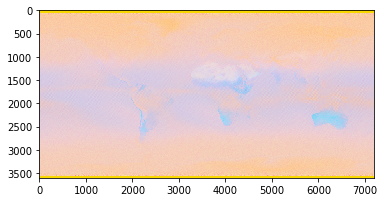

In [3]:
rgb = np.dstack((r[0], g[0], b[0]))
en_rgb = enhance_rgb(rgb)
plt.imshow(en_rgb)
plt.show()

#### RLT, trial 1  
_coeff_ is the maximum value of blue band;  
_scale method_ is RLT;  
_scale factors_ are [1, 1, 1];

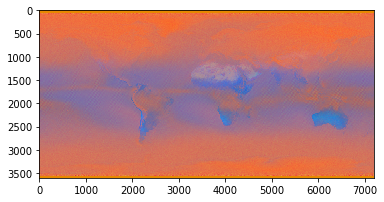

In [4]:
# RLT but not set scale_factors
en_rgb = enhance_rgb(rgb, scale_method='RLT')
plt.imshow(en_rgb)
plt.show()

#### RLT, trial 2 
_coeff_ is the maximum value of blue band;  
_scale method_ is RLT;  
_scale factors_ are [1, 1.2, 1];

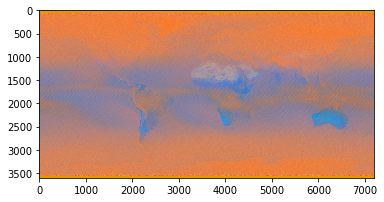

In [6]:
# RLT and set scale_factors
en_rgb = enhance_rgb(rgb, scale_method='RLT', scale_factors=[1, 1.2, 1])
plt.imshow(en_rgb)
plt.show()

## Running mean test (April 6, 2018)  
Try calculating the moving average (finally get 365 images) based on the climatic daily mean values.  
This part belongs to the "process".  
The op. code will be named as "postprocess_running_mean.py" and saved to "process" folder.

In [47]:
from my_module import np, os, tqdm

daily_mean_folder = "/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/daily_mean"

#### Try on band 1  
Basically there should be a function fulfills the following criterion:  
1) a parameter stores the data folder: data_folder  
2) a parameter stores the user defined band: iband  
3) a parameter stores the number of running window: num_window  
4)* an array with the same size (3) stores the filter: iflter (default is [])  
5) the output should contain 365 (or 366?) images with the same shape array: avg_moving

In [115]:
# 预备工作
data_folder = daily_mean_folder
iband = 1
num_window = 61 # should be an odd number


#
def get_fname_bandindex(iband):
    
    iband = str(iband)
    
    # predefined categories
    VIS = np.array([1, 2, 3, 4, 5, 6, 7], dtype=str)
    SWIR_P1 = np.array([8,9,10,11,12,'13lo','13hi','14lo'], dtype=str)
    SWIR_P2 = np.array(['14hi',15,16,17,18,19,26], dtype=str)
    LW_P1 = np.array([20,21,22,23,24,25,27,28], dtype=str)
    LW_P2 = np.array([29,30,31,32,33,34,35,36], dtype=str)
    
    # retrieve the index of band in a specified category as well as the data file
    if iband in VIS:
        ifile = "VIS_{}.npz"
        iband_idx = np.where(iband==VIS)[0][0]
    elif iband in SWIR_P1:
        ifile = "SWIR_P1_{}.npz"
        iband_idx = np.where(iband==SWIR_P1)[0][0]
    elif iband in SWIR_P2:
        ifile = "SWIR_P2_{}.npz"
        iband_idx = np.where(iband==SWIR_P2)[0][0]
    elif iband in LW_P1:
        ifile = "LW_P1_{}.npz"
        iband_idx = np.where(iband==LW_P1)[0][0]
    elif iband in LW_P2:
        ifile = "LW_P2_{}.npz"
        iband_idx = np.where(iband==LW_P2)[0][0]
    
    return ifile, iband_idx


# 
def get_process_days(iday, num_window):
    # successsive 3 years
    _days_3yrs = np.append(np.append(range(1, 366), range(1, 366)), range(1, 366)) 
    # given a day (iday) as the central day, the required processing days are
    process_days = _days_3yrs[365+iday-(num_window-1)/2-1:365+iday+(num_window-1)/2]
    
    return process_days


# main function, process one time moving average
def main_process_one_time(iband, iday, num_window):
    
    # 1. use get_fname_bandindex to retrieve fname and band_idx
    fname, band_idx = get_fname_bandindex(iband)
    
    # 2. use get_process_days to retrieve process_days
    process_days = get_process_days(iday, num_window)
    
    # 3. do process
    sum_moving = np.zeros((3600, 7200))
    for iday in process_days:
        print iday
        data_file = fname.format(str(iday).zfill(3))
        data_path = os.path.join(data_folder, data_file)
        data = np.load(data_path)['mean_rad'][:, :, band_idx]
        sum_moving = np.nansum([sum_moving, data], axis=0)

    avg_moving = np.nan_to_num(sum_moving / iday)
    toimage(avg_moving).save("avg_moving_{}_{}.png".format(iband, iday))

In [116]:
main_process_one_time(iband, 1, 31)

351


ValueError: could not broadcast input array from shape (3600,7200,7) into shape (3600,7200)

__test 1__: how many days (1 band) can we store in a single array?  
__answer 1__: ~20  
__test 2__: how many nodes (cores) are required to finish this task?  
__answer 2__: To maximize the utility of usage, ...  
__test 3__: should I implement the feature allowing filter input?  
__answer 3__: Yes  

In [70]:
fname, band_idx = get_fname_bandindex(iband)

tmp_array = np.zeros((3600, 7200))
for iday in range(1, 367):
    data_file = fname.format(str(iday).zfill(3))
    data_path = os.path.join(data_folder, data_file)
    data = np.load(data_path)['mean_rad'][:, :, band_idx]
    tmp_array = np.nansum([tmp_array, data], axis=0)
    
    data_new = np.nan_to_num(tmp_array/iday)
    toimage(data_new).save("{}.png".format(iday))
    

  0%|          | 0/307 [00:00<?, ?it/s]/mnt/bwpy/single/usr/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # This is added back by InteractiveShellApp.init_path()
 38%|███▊      | 117/307 [1:00:06<1:37:37, 30.83s/it]

KeyboardInterrupt: 

## Running mean validation (April 11, 2018)  
Finally BWs processed the 61-day moving average data. Now I can have a check on the results.

In [ ]:
import sys
sys.path.append("/u/sciteam/smzyz/applications/lib/python2.7/site-packages")
from my_module import np, plt, os, toimage, tqdm
from my_module.plot import scale_image_2d, enhance_rgb


def load_data(iband, iday):
    fname = 'b{}_{}.npz'.format(iband, iday)
    data_dir = os.path.join(WORKING_DIR, fname)
    data_file = np.load(data_dir)
    data = data_file['avg_moving'][:]
    return data


WORKING_DIR = "/u/sciteam/smzyz/scratch/results/MODIS_ClimateMarble_005deg/moving_average"


for iday in tqdm(range(1, 366)):
    r = load_data(1, iday)
    g = load_data(4, iday)
    b = load_data(3, iday)
    
    rgb = np.dstack((r, g, b))
    
    # enhance and save image
#     enhanced_image = scale_image_2d(data, method='discrete', scale_factor=1)
    enhanced_image = enhance_rgb(rgb, scale_method='RLT', scale_factors=[1, 1, 1])
    toimage(enhanced_image).save('{}.png'.format(iday))

  0%|          | 0/365 [00:00<?, ?it/s]/mnt/bwpy/single/usr/lib/python2.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
 17%|█▋        | 63/365 [33:24<2:40:07, 31.81s/it]

KeyboardInterrupt: 

## Check MISR time

#### DOWNLOAD some MISR data to start with  
See ../process/MISR_downloader.py

#### Print cross-equator UTC time  
Working on the DF data so it is not exactly the satellite crossing time.

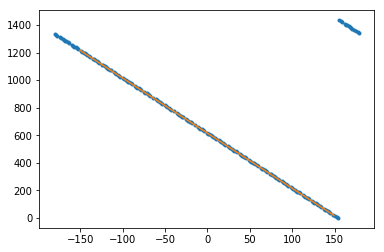

LinregressResult(slope=-3.999922981849275, intercept=615.720833832778, rvalue=-0.99999971137166144, pvalue=0.0, stderr=0.00022588995466164128)


In [50]:
from my_module import np, mtk, os, tqdm, plt, linregress


data_dir = "/u/sciteam/smzyz/scratch/data/MISR/MI1B2E.003/2010"


lon = []
time = []

for ifile in os.listdir(data_dir):
    if ifile.endswith('.hdf'):
        idata = os.path.join(data_dir, ifile)
        time_metadata = mtk.MtkFile(idata).time_metadata_read()
        somxy = mtk.bls_to_somxy(time_metadata.path, 1100, 91, 20., 0.)
        latlon = mtk.somxy_to_latlon(time_metadata.path, somxy[0], somxy[1])
        time_latlon = time_metadata.pixel_time(somxy[0], somxy[1])
#         print "{:7.2f}".format(latlon[1]), time_latlon[11:16]
        lon.append(latlon[1])
        time.append(int(time_latlon[11:16].split(':')[0])*60+int(time_latlon[11:16].split(':')[1]))

        
lon = np.array(lon)
time = np.array(time)
plt.plot(lon, time, '.')
plt.plot(np.arange(-150, 150), -4*np.arange(-150, 150)+615.720833832778)
plt.show()


print linregress(lon[lon<150], time[lon<150])

Results prove that the equator-crossing time is ~10:30 AM local time for Terra satellite.  
It should be noted that the MISR 9 angles have 7 minutes interval in total.   

## 2B-CLDCLASS-LIDAR data  
Data are stored under _/scratch/sciteam/yulanh/CLDCLASS_. There are 4 years data (2007--2010), and data is orbit-based. Each data file is ~10 MB.

### First Phase

__Let's__ visualize some data first.

In [10]:
from my_module import np, SD, plt, os, Basemap, tqdm
from my_module.data.comm import latlon_to_idx
# Modules used to read lat/lon
from pyhdf.HDF import *
from pyhdf.VS import *


def read_latlon(data_dir):
    h4f = HDF(data_dir)
    vs = h4f.vstart() 
    Latitude = vs.attach('Latitude')
    Longitude = vs.attach('Longitude')

    lats = np.array(Latitude[:])
    lons = np.array(Longitude[:])

    Latitude.detach() # "close" the vdata
    Longitude.detach() # "close" the vdata
    vs.end() # terminate the vdata interface
    h4f.close()
    
    return lats, lons


def read_cloudlayer(data_dir):
    h4f = HDF(data_dir)
    vs = h4f.vstart() 
    Cloudlayer = vs.attach('Cloudlayer')

    data_out = np.array(Cloudlayer[:])

    Cloudlayer.detach() # "close" the vdata
    vs.end() # terminate the vdata interface
    h4f.close()
    
    return data_out


def read_SD_variable(data_dir, var_name):
    h4f = SD(data_dir)
    data_out = h4f.select(var_name)[:]
    
    return data_out

In [18]:
iyr = 2007
imon = 2
WORKING_DIR = "/scratch/sciteam/yulanh/CLDCLASS/{0:}/{0:}{1:}".format(iyr, str(imon).zfill(2))
data_fnames = np.array(os.listdir(WORKING_DIR))
data_orbits = np.array([int(i.split('_')[1]) for i in data_fnames])
print "Orbit ranges from {} to {} in {}.{}".format(min(data_orbits), max(data_orbits), iyr, imon)


iorbit = 4058
data_file = data_fnames[data_orbits==iorbit][0]
data_dir = os.path.join(WORKING_DIR, data_file)

# h4f = SD('')
lats, lons = read_latlon(data_dir)


iorbit = 4291
data_file = data_fnames[data_orbits==iorbit][0]
data_dir = os.path.join(WORKING_DIR, data_file)

# h4f = SD('')
lats1, lons1 = read_latlon(data_dir)

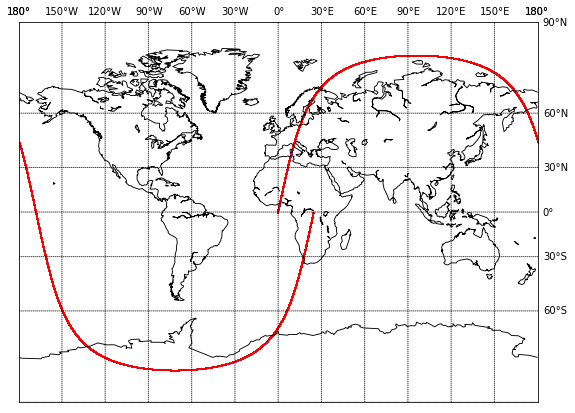

In [19]:
plt.figure(figsize=(13, 7))
m = Basemap(projection='mill', lon_0=0, resolution='c')
m.drawcoastlines(color='k', linewidth=0.9)
m.drawmeridians(np.arange(-180.,181,30.), labels=[False,True,True,False])
m.drawparallels(np.arange(90.,-91,-30.), labels=[False,True,True,False])
im = m.scatter(lons,lats,c='b',latlon=True,marker='s',s=1, 
                cmap='coolwarm', alpha=0.2)
im = m.scatter(lons1,lats1,c='r',latlon=True,marker='s',s=1, 
                cmap='coolwarm', alpha=0.2)
plt.show()

In [21]:
data_dirs = []
for iyr in range(2007, 2011):
    for imon in range(1, 13):
        WORKING_DIR = "/scratch/sciteam/yulanh/CLDCLASS/{0:}/{0:}{1:}".format(iyr, str(imon).zfill(2))
        for ifile in os.listdir(WORKING_DIR):
            if ifile.endswith('.hdf'):
                data_dirs.append(os.path.join(WORKING_DIR, ifile))

data_dirs = np.array(data_dirs)
data_orbits = np.array([int(i.split('_')[1]) for i in data_dirs])

np.savez('/u/sciteam/smzyz/git_projects/CloudSatCM/CLDCLASS_filenames.npz', dirs=data_dirs, orbits=data_orbits)

### Second phase  

我已将所有CLDCLASS数据文件路径保存在 CLDCLASS_filenames.npz 中，剩下的只需再次确认 repeat cycle 为233后，就能对所有4年的数据进行处理。  

Confirmed. 需要注意的是，CloudSat不像MISR，its ground lat/lon slightly changes for each orbit for the same path number. 但依旧可以认为是同一点？

In [3]:
CloudSat_files = np.load('/u/sciteam/smzyz/git_projects/CloudSatCM/CLDCLASS_filenames.npz')
data_dirs = CloudSat_files['dirs'][:]
data_orbits = CloudSat_files['orbits'][:]

print data_orbits

[ 3804  4005  3928 ..., 24600 24632 24557]


In [9]:
plt.figure(figsize=(13, 7))
m = Basemap(projection='mill', lon_0=0, resolution='c')
m.drawcoastlines(color='k', linewidth=0.9)
m.drawmeridians(np.arange(-180.,181,30.), labels=[False,True,True,False])
m.drawparallels(np.arange(90.,-91,-30.), labels=[False,True,True,False])


# let orbit 3608 be Path 1, then next orbit number (if exists) of Path 1 would be 3608+233=3841.
test_orbit = 3608
for iorbit in range(test_orbit, 24861, 233):
#     print ">> Working on oribt: {}".format(iorbit)
    if len(data_dirs[data_orbits==iorbit]) == 0:
        continue
    data_dir = data_dirs[data_orbits==iorbit][0]
    lats, lons = read_latlon(data_dir)
    print ">> Working on oribt: {}".format(iorbit)
    print lats.ravel()[37080]
    im = m.scatter(lons,lats,c='b',latlon=True,marker='s',s=1, 
                    cmap='coolwarm', alpha=0.2)

plt.show()

>> Working on oribt: 3608
0.00721260812134
>> Working on oribt: 4074
0.00918426085263
>> Working on oribt: 4307
0.00750323617831
>> Working on oribt: 4540
0.0078969663009
>> Working on oribt: 4773
0.00499778985977
>> Working on oribt: 5006
0.00157931004651
>> Working on oribt: 5239
0.0100333914161
>> Working on oribt: 5472
0.00629153521731
>> Working on oribt: 5705
0.00478343199939
>> Working on oribt: 5938


IndexError: index 37080 is out of bounds for axis 0 with size 37080

In [5]:
plt.figure(figsize=(13, 7))
m = Basemap(projection='mill', lon_0=0, resolution='c')
m.drawcoastlines(color='k', linewidth=0.9)
m.drawmeridians(np.arange(-180.,181,30.), labels=[False,True,True,False])
m.drawparallels(np.arange(90.,-91,-30.), labels=[False,True,True,False])


# let orbit 3608 be Path 1, then next orbit number (if exists) of Path 1 would be 3608+233=3841.
test_orbit = 3608
for iorbit in range(test_orbit, test_orbit+233):
#     print 
    if len(data_dirs[data_orbits==iorbit]) == 0:
        continue
    data_dir = data_dirs[data_orbits==iorbit][0]
    lats, lons = read_latlon(data_dir)
    print ">> Working on oribt: {}".format(iorbit), lats.shape
    im = m.scatter(lons,lats,c='b',latlon=True,marker='s',s=1, 
                    cmap='coolwarm', alpha=0.2)

plt.show()

>> Working on oribt: 3608 (37081, 1)
>> Working on oribt: 3609 (37081, 1)
>> Working on oribt: 3610 (37082, 1)
>> Working on oribt: 3611 (37083, 1)
>> Working on oribt: 3612 (37081, 1)
>> Working on oribt: 3613 (37081, 1)
>> Working on oribt: 3614 (37081, 1)
>> Working on oribt: 3615 (37081, 1)
>> Working on oribt: 3616 (37081, 1)
>> Working on oribt: 3617 (37082, 1)
>> Working on oribt: 3618 (37082, 1)
>> Working on oribt: 3619 (37081, 1)
>> Working on oribt: 3620 (37082, 1)
>> Working on oribt: 3621 (37081, 1)
>> Working on oribt: 3622 (37081, 1)
>> Working on oribt: 3623 (37081, 1)
>> Working on oribt: 3624 (37082, 1)
>> Working on oribt: 3625 (37082, 1)
>> Working on oribt: 3626 (37082, 1)
>> Working on oribt: 3627 (37081, 1)
>> Working on oribt: 3628 (37081, 1)
>> Working on oribt: 3629 (37081, 1)
>> Working on oribt: 3630 (37081, 1)
>> Working on oribt: 3631 (37082, 1)
>> Working on oribt: 3632 (37081, 1)
>> Working on oribt: 3633 (37082, 1)
>> Working on oribt: 3634 (37082, 1)
>

/mnt/bwpy/single/usr/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3229: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


KeyboardInterrupt: 

### Third Phase
According to 玉兰姐, 只需要用 CloudLayerBase 和 CloudLayerTop 这两个量即可。但感觉需要区分 ascending 和 descending？

In [46]:

RESOLUTION = 1.0 # degree
NUM_PER_DEGREE = int(1.0/RESOLUTION)

cld_array = np.zeros((180*NUM_PER_DEGREE, 360*NUM_PER_DEGREE))
tot_array = np.zeros((180*NUM_PER_DEGREE, 360*NUM_PER_DEGREE))

# iorbit = 5000
for iorbit in tqdm(range(3608, 10000)):
    try:
        data_dir = data_dirs[data_orbits==iorbit][0]
        lats, lons = read_latlon(data_dir)
        lats_int = np.array(lats.ravel(), dtype='int16')
        lats_decimal = lats.ravel() - lats_int
        lons_int = np.array(lons.ravel(), dtype='int16')
        lons_decimal = lons.ravel() - lons_int

        cloudlayers = read_cloudlayer(data_dir).ravel()
    except:
        print ">> Cannot access data file: {}, program continues...".format(data_dir)
    
    for i, icld in enumerate(cloudlayers):
        idx_lat, idx_lon = latlon_to_idx(lats_int[i], lats_decimal[i], lons_int[i], lons_decimal[i], NUM_PER_DEGREE)
        if icld > 0:
            cld_array[idx_lat, idx_lon] += 1 # 有云
        tot_array[idx_lat, idx_lon] += 1

 14%|█▍        | 71/500 [02:31<15:17,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007101115937_05070_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 14%|█▍        | 72/500 [02:33<15:12,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007101115937_05070_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 17%|█▋        | 84/500 [03:28<17:14,  2.49s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 17%|█▋        | 85/500 [03:30<17:07,  2.48s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 17%|█▋        | 86/500 [03:32<17:01,  2.47s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 17%|█▋        | 87/500 [03:33<16:54,  2.46s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 18%|█▊        | 88/500 [03:35<16:47,  2.45s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 18%|█▊        | 89/500 [03:36<16:41,  2.44s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 18%|█▊        | 90/500 [03:38<16:35,  2.43s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 18%|█▊        | 91/500 [03:40<16:29,  2.42s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 18%|█▊        | 92/500 [03:41<16:23,  2.41s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 19%|█▊        | 93/500 [03:43<16:17,  2.40s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 19%|█▉        | 94/500 [03:44<16:11,  2.39s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 19%|█▉        | 95/500 [03:46<16:05,  2.38s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 19%|█▉        | 96/500 [03:48<16:00,  2.38s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 19%|█▉        | 97/500 [03:49<15:54,  2.37s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 20%|█▉        | 98/500 [03:51<15:49,  2.36s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 20%|█▉        | 99/500 [03:53<15:43,  2.35s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 20%|██        | 100/500 [03:54<15:38,  2.35s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 20%|██        | 101/500 [03:56<15:33,  2.34s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 20%|██        | 102/500 [03:57<15:28,  2.33s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 21%|██        | 103/500 [03:59<15:22,  2.32s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 21%|██        | 104/500 [04:01<15:17,  2.32s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 21%|██        | 105/500 [04:02<15:12,  2.31s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 21%|██        | 106/500 [04:04<15:07,  2.30s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 21%|██▏       | 107/500 [04:05<15:03,  2.30s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 22%|██▏       | 108/500 [04:07<14:58,  2.29s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 22%|██▏       | 109/500 [04:09<14:53,  2.29s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 22%|██▏       | 110/500 [04:10<14:48,  2.28s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 22%|██▏       | 111/500 [04:12<14:44,  2.27s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 22%|██▏       | 112/500 [04:13<14:39,  2.27s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 23%|██▎       | 113/500 [04:15<14:35,  2.26s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 23%|██▎       | 114/500 [04:17<14:30,  2.26s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 23%|██▎       | 115/500 [04:18<14:26,  2.25s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 23%|██▎       | 116/500 [04:20<14:22,  2.25s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 23%|██▎       | 117/500 [04:22<14:17,  2.24s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 24%|██▎       | 118/500 [04:23<14:13,  2.23s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 24%|██▍       | 119/500 [04:25<14:09,  2.23s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 24%|██▍       | 120/500 [04:26<14:05,  2.22s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 24%|██▍       | 121/500 [04:28<14:01,  2.22s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 24%|██▍       | 122/500 [04:30<13:57,  2.21s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 25%|██▍       | 123/500 [04:31<13:53,  2.21s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 25%|██▍       | 124/500 [04:33<13:49,  2.21s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 25%|██▌       | 125/500 [04:35<13:45,  2.20s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 25%|██▌       | 126/500 [04:36<13:41,  2.20s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 25%|██▌       | 127/500 [04:38<13:37,  2.19s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 26%|██▌       | 128/500 [04:39<13:33,  2.19s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 26%|██▌       | 129/500 [04:41<13:29,  2.18s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 26%|██▌       | 130/500 [04:43<13:25,  2.18s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 26%|██▌       | 131/500 [04:44<13:22,  2.17s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 26%|██▋       | 132/500 [04:46<13:18,  2.17s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 27%|██▋       | 133/500 [04:48<13:14,  2.17s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 27%|██▋       | 134/500 [04:49<13:11,  2.16s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 27%|██▋       | 135/500 [04:51<13:07,  2.16s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 27%|██▋       | 136/500 [04:52<13:03,  2.15s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 27%|██▋       | 137/500 [04:54<13:00,  2.15s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 28%|██▊       | 138/500 [04:56<12:56,  2.15s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 28%|██▊       | 139/500 [04:57<12:53,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 28%|██▊       | 140/500 [04:59<12:49,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 28%|██▊       | 141/500 [05:01<12:46,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 28%|██▊       | 142/500 [05:02<12:43,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 29%|██▊       | 143/500 [05:04<12:39,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 29%|██▉       | 144/500 [05:05<12:36,  2.12s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007102092506_05083_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 31%|███▏      | 157/500 [05:34<12:10,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007107094337_05156_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 32%|███▏      | 159/500 [05:38<12:05,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007107130123_05158_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 32%|███▏      | 161/500 [05:42<12:00,  2.12s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007107161909_05160_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 42%|████▏     | 211/500 [07:33<10:20,  2.15s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007111024321_05210_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 51%|█████     | 256/500 [09:12<08:46,  2.16s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 51%|█████▏    | 257/500 [09:14<08:44,  2.16s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 52%|█████▏    | 258/500 [09:16<08:41,  2.16s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 52%|█████▏    | 259/500 [09:17<08:38,  2.15s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 52%|█████▏    | 260/500 [09:19<08:36,  2.15s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 52%|█████▏    | 261/500 [09:20<08:33,  2.15s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 52%|█████▏    | 262/500 [09:22<08:30,  2.15s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 53%|█████▎    | 263/500 [09:24<08:28,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 53%|█████▎    | 264/500 [09:25<08:25,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 53%|█████▎    | 265/500 [09:27<08:23,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 53%|█████▎    | 266/500 [09:28<08:20,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 53%|█████▎    | 267/500 [09:30<08:17,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 54%|█████▎    | 268/500 [09:32<08:15,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 54%|█████▍    | 269/500 [09:33<08:12,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 54%|█████▍    | 270/500 [09:35<08:10,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 54%|█████▍    | 271/500 [09:37<08:07,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 54%|█████▍    | 272/500 [09:38<08:05,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 55%|█████▍    | 273/500 [09:40<08:02,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 55%|█████▍    | 274/500 [09:41<07:59,  2.12s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 55%|█████▌    | 275/500 [09:43<07:57,  2.12s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 55%|█████▌    | 276/500 [09:45<07:54,  2.12s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 55%|█████▌    | 277/500 [09:46<07:52,  2.12s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 56%|█████▌    | 278/500 [09:48<07:49,  2.12s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 56%|█████▌    | 279/500 [09:49<07:47,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 56%|█████▌    | 280/500 [09:51<07:44,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 56%|█████▌    | 281/500 [09:53<07:42,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 56%|█████▋    | 282/500 [09:54<07:39,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 57%|█████▋    | 283/500 [09:56<07:37,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 57%|█████▋    | 284/500 [09:57<07:34,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 57%|█████▋    | 285/500 [09:59<07:32,  2.10s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 57%|█████▋    | 286/500 [10:01<07:29,  2.10s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 57%|█████▋    | 287/500 [10:02<07:27,  2.10s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007114045308_05255_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 61%|██████    | 304/500 [10:40<06:52,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007117115935_05303_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 62%|██████▏   | 309/500 [10:50<06:42,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007117201400_05308_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 64%|██████▍   | 320/500 [11:14<06:19,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007118142144_05319_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 68%|██████▊   | 340/500 [11:58<05:38,  2.11s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200704/2007119231925_05339_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 89%|████████▊ | 443/500 [15:47<02:01,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007127010430_05442_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 89%|████████▉ | 444/500 [15:49<01:59,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007127010430_05442_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 89%|████████▉ | 445/500 [15:51<01:57,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007127010430_05442_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 89%|████████▉ | 446/500 [15:52<01:55,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007127010430_05442_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 93%|█████████▎| 463/500 [16:30<01:19,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007128100211_05462_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 93%|█████████▎| 464/500 [16:31<01:16,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007128100211_05462_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 93%|█████████▎| 465/500 [16:33<01:14,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007128100211_05462_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 93%|█████████▎| 466/500 [16:35<01:12,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007128100211_05462_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 94%|█████████▎| 468/500 [16:38<01:08,  2.13s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007128181636_05467_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


 99%|█████████▉| 496/500 [17:40<00:08,  2.14s/it]

>> Cannot access data file: /scratch/sciteam/yulanh/CLDCLASS/2007/200705/2007130162522_05495_CS_2B-CLDCLASS-LIDAR_GRANULE_P_R04_E02.hdf, program continues...


100%|██████████| 500/500 [17:49<00:00,  2.14s/it]


/mnt/a/u/sciteam/smzyz/applications/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


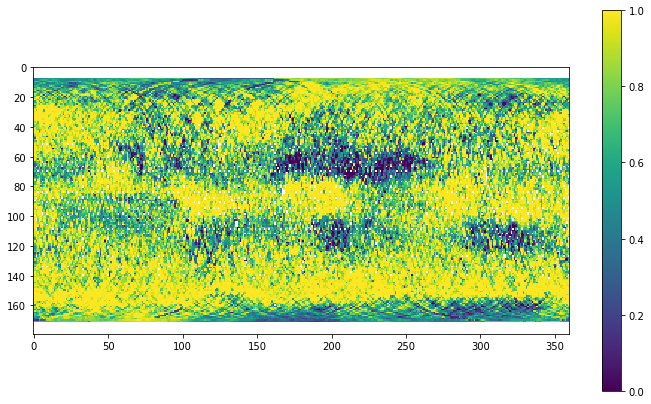

In [47]:
plt.figure(figsize=(12, 7))
plt.imshow(1.0*cld_array/tot_array)
plt.colorbar()
plt.show()

### 4th Phase

__Task__: get one path, bin data only by laitude (let's say 1 degree resolution), vertical resolution (let's say 500 m) so that vertically we will have 40 layers (up to 20 km). The final output will be 180 * 40.  

To accomplish this, we need to write another function accounting for the idx_height: use each cloud top to determine the uppermost vertical index and cloud base to determine the lowermost vertical index.

In [106]:
# modules
from my_module import np, SD, plt, os, Basemap, tqdm
from my_module.data.comm import latlon_to_idx
# Modules used to read lat/lon
from pyhdf.HDF import *
from pyhdf.VS import *


# functions
def read_latlon(data_dir):
    """
    used in the function {count_one_path(ipath)}
    """
    h4f = HDF(data_dir)
    vs = h4f.vstart() 
    Latitude = vs.attach('Latitude')
    Longitude = vs.attach('Longitude')

    lats = np.array(Latitude[:])
    lons = np.array(Longitude[:])

    Latitude.detach() # "close" the vdata
    Longitude.detach() # "close" the vdata
    vs.end() # terminate the vdata interface
    h4f.close()
    
    return lats, lons


def read_cloudlayer(data_dir):
    """
    used in the function {count_one_path(ipath)}
    """
    h4f = HDF(data_dir)
    vs = h4f.vstart() 
    Cloudlayer = vs.attach('Cloudlayer')

    data_out = np.array(Cloudlayer[:])

    Cloudlayer.detach() # "close" the vdata
    vs.end() # terminate the vdata interface
    h4f.close()
    
    return data_out


def read_SD_variable(data_dir, var_name):
    """
    used in the function {count_one_path(ipath)}
    """
    h4f = SD(data_dir)
    data_out = h4f.select(var_name)[:]
    
    return data_out


def count_cld_layer(ilayer_num, ibase_int, itop_int):
    """
    used in the function {count_one_path(ipath)}
    """
    cld_layer = np.zeros((40))
    for ilayer in range(ilayer_num):
        ibase = ibase_int[ilayer]
        itop = itop_int[ilayer]

        cld_layer[ibase:itop+1] = 1
    
    return cld_layer


def count_one_path(ipath):
    """
    Starts from orbit 3609 (ipath=1) and so on.
    """
    cld_array = np.zeros((180*NUM_PER_DEGREE, 40))
    tot_array = np.zeros((180*NUM_PER_DEGREE, 40))

    # main loop of each orbit
    for iorbit in tqdm(range(3609+ipath-1, 24861, 233)):
        try:
            data_dir = data_dirs[data_orbits==iorbit][0]
        except:
    #         print ">> No data orbit: {}".format(iorbit)
            continue

        # read geolocation
        lats, lons = read_latlon(data_dir)
        lats, lons = read_latlon(data_dir)
        lats_int = np.array(lats.ravel(), dtype='int16')
        lats_decimal = lats.ravel() - lats_int
        lons_int = np.array(lons.ravel(), dtype='int16')
        lons_decimal = lons.ravel() - lons_int

        # read cloud layer
        cloud_layer = read_cloudlayer(data_dir).ravel()
        cloud_base = read_SD_variable(data_dir, 'CloudLayerBase')
        cloud_base_int = np.array(cloud_base/0.5, dtype='int16')
        cloud_top = read_SD_variable(data_dir, 'CloudLayerTop')
        cloud_top_int = np.array(cloud_top/0.5, dtype='int16')


        # sub-loop of each sample
        length = len(cloud_layer)
        for i in xrange(length/4, 3*length/4):
            idx_lat, _ = latlon_to_idx(lats_int[i], lats_decimal[i], lons_int[i], lons_decimal[i], NUM_PER_DEGREE)
            cld_sample = count_cld_layer(cloud_layer[i], cloud_base_int[i], cloud_top_int[i])
            tot_sample = np.ones_like((cld_layer))

            # add results to the total
            cld_array[idx_lat] += cld_sample
            tot_array[idx_lat] += tot_sample
    
    return cld_array, tot_array


# definition
RESOLUTION = 1.0 # degree
NUM_PER_DEGREE = int(1.0/RESOLUTION)
VRESOLUTION = 0.5 # meter
NUM_PER_DEGREE = int(1.0/RESOLUTION)

CloudSat_files = np.load('/u/sciteam/smzyz/git_projects/CloudSatCM/CLDCLASS_filenames.npz')
data_dirs = CloudSat_files['dirs'][:]
data_orbits = CloudSat_files['orbits'][:]

In [107]:

fnl_tot_array = []
fnl_cld_array = [] # final should be in shape of (233, 180, 40)

for ipath in range(1, 234):
    cld_array, tot_array = count_one_path(ipath)
    fnl_cld_array.append(cld_array)
    fnl_tot_array.append(tot_array)



  3%|▎         | 3/91 [00:08<04:02,  2.76s/it]Exception KeyError: KeyError(<weakref at 0x2aaae5cb1940; to 'tqdm' at 0x2aaaae48df50>,) in <object repr() failed> ignored


KeyboardInterrupt: 

In [108]:
np.savez('cloud_distribution_by_path.npz', tot_array=fnl_tot_array, cld_array=fnl_cld_array)

71

/mnt/bwpy/single/usr/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.


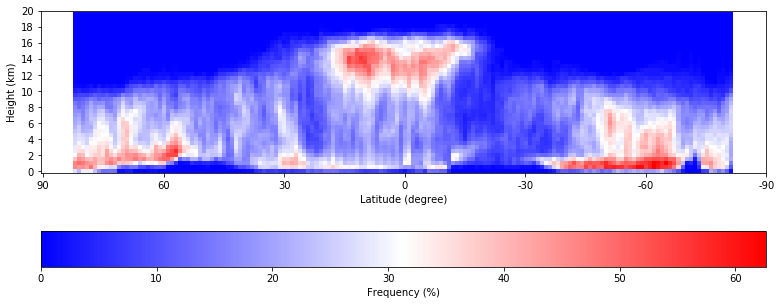

In [102]:
freq_cld = 100. * cld_array/tot_array

plt.figure(figsize=(13, 7))
plt.imshow(freq_cld.transpose(), origin='lower', cmap='bwr')
plt.xticks(range(0, 181, 30), range(90, -91, -30))
plt.yticks(range(0, 41, 4), range(0, 21, 2))
plt.colorbar(orientation='horizontal', label='Frequency (%)')
plt.ylabel('Height (km)')
plt.xlabel('Latitude (degree)')
plt.savefig('orbit_3609.png', dpi=300)
plt.show()

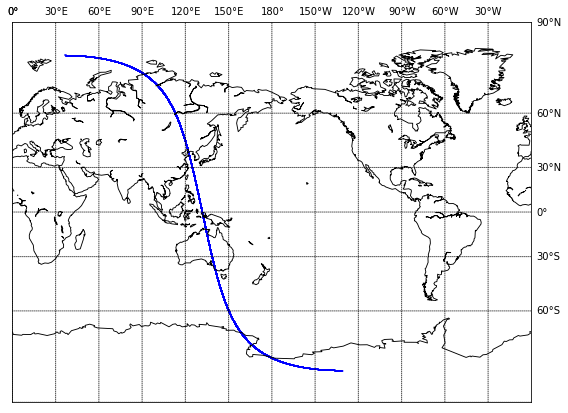

In [104]:
iorbit = 3609

lats, lons = read_latlon(data_dir)
    
plt.figure(figsize=(13, 7))
m = Basemap(projection='mill', lon_0=180, resolution='c')
m.drawcoastlines(color='k', linewidth=0.9)
m.drawmeridians(np.arange(-180.,181,30.), labels=[False,True,True,False])
m.drawparallels(np.arange(90.,-91,-30.), labels=[False,True,True,False])
im = m.scatter(lons[9270:-9270].ravel(),lats[9270:-9270].ravel(),c='b',latlon=True,marker='s',s=1, 
                cmap='coolwarm', alpha=0.2)
plt.savefig('map_3609.png', dpi=300)
plt.show()